# Learning convolutional kernels using biologically-inspired BTSP

In [594]:
import torch
import matplotlib.pyplot as plt
import EIANN.plot as pt

from tqdm.autonotebook import tqdm
import numpy as np
import matplotlib.gridspec as gs
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [595]:
# Load MNIST data
import torchvision
from torchvision import transforms
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False, transform=transforms.ToTensor())
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=False, download=False, transform=transforms.ToTensor())

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(MNIST_train_dataset, batch_size=1, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(MNIST_test_dataset, batch_size=10000, shuffle=False)

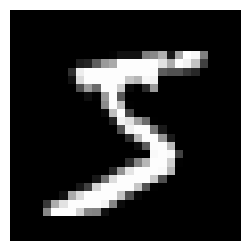

In [596]:
# plot example image
fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.imshow(MNIST_train_dataset[0][0][0], cmap='gray')
ax.axis('off')
plt.show()

## Standard CNN

In [597]:
# Simple convolutional network in PyTorch
class CNN(torch.nn.Module):
    def __init__(self, kernel_size, num_conv_filters):
        super().__init__()
        self.kernel_size = kernel_size
        self.num_conv_filters = num_conv_filters
        original_image_dim = 28
        dim_after_maxpool = original_image_dim // 2
        num_output_classes = 10
        self.conv1 = torch.nn.Conv2d(1, num_conv_filters, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(num_conv_filters*dim_after_maxpool*dim_after_maxpool, num_output_classes)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, self.num_conv_filters*14*14)
        x = self.fc1(x)
        return x
    
    def train(self, num_train_steps, train_dataloader, learning_rate):
        self.num_train_steps = num_train_steps
        # self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_loss = []
        self.train_accuracy = []
        running_loss = []
        running_train_accuracy = []
        epoch = 0
        n_epochs = 1

        for i, data in tqdm(enumerate(train_dataloader, 0), leave=False, total=len(train_dataloader), desc=f'Epoch {epoch+1}/{n_epochs}'):
            inputs, labels = data
            self.optimizer.zero_grad()
            outputs = self.forward(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())
            running_train_accuracy.append((outputs.argmax(1) == labels))
            if i % 1000 == 999: # every 1000 mini-batches, save the loss and accuracy
                self.train_loss.append(np.mean(running_loss))
                self.train_accuracy.append(np.mean(running_train_accuracy))
                running_loss = []
                running_train_accuracy = []
                
            if i >= num_train_steps-1:
                break
    
    def plot_conv1_receptive_fields(self):
        num_rows = int(np.ceil(np.sqrt(self.num_conv_filters)))
        num_cols = int(np.ceil(self.num_conv_filters / num_rows))
        fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 6))
        for i in range(len(ax.flatten())):
            if i < self.num_conv_filters:
                ax.flatten()[i].imshow(self.conv1.weight[i][0].detach().numpy(), cmap='gray')
            ax.flatten()[i].axis('off')
        plt.tight_layout(w_pad=0.5, h_pad=0.5)
        plt.suptitle(f'Backprop receptive fields after {self.num_train_steps} images', y=1.02)
        plt.show()
        return fig
    


In [598]:
# # Create the network
# torch.manual_seed(0)
# cnnBP = CNN(kernel_size=7, num_conv_filters=30)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

# # Test the network before training
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_dataloader:
#         images, labels = data
#         outputs = cnn(images)
#         correct += (outputs.argmax(1) == labels).float().sum().item()
#         total += labels.size(0)
# print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total:.2f}%')

# # Train the network
# train_loss = []
# val_loss = []
# train_accuracy = []
# val_accuracy = []

# n_epochs = 1
# cnnBP.num_train_steps = 100

# for epoch in tqdm(range(n_epochs)):
#     running_loss = []
#     running_train_accuracy = []
#     for i, data in tqdm(enumerate(train_dataloader, 0), leave=False, total=len(train_dataloader), desc=f'Epoch {epoch+1}/{n_epochs}'):
#         inputs, labels = data
#         optimizer.zero_grad()
#         outputs = cnn(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss.append(loss.item())
#         running_train_accuracy.append((outputs.argmax(1) == labels))
#         if i % 1000 == 999: # print every 1000 mini-batches
#             train_loss.append(np.mean(running_loss))
#             train_accuracy.append(np.mean(running_train_accuracy))
#             running_loss = []
#             running_train_accuracy = []

#             test_data = next(iter(test_dataloader))
#             test_inputs, test_labels = test_data
#             test_outputs = cnnBP(test_inputs)
#             test_loss = criterion(test_outputs, test_labels)
#             val_loss.append(test_loss.item())
#             val_accuracy.append((test_outputs.argmax(1) == test_labels).float().mean().item())
            
#         if i >= cnnBP.num_train_steps-1:
#             break

# # Plot the results
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].plot(train_loss, label='Train')
# ax[0].plot(val_loss, label='Validation')
# ax[0].set_xlabel('train step (x1000)')
# ax[0].set_ylabel('Loss')
# ax[0].legend()
# ax[1].plot(train_accuracy, label='Train')
# ax[1].plot(val_accuracy, label='Validation')
# ax[1].set_xlabel('train step (x1000)')
# ax[1].set_ylabel('Accuracy')
# ax[1].legend()
# plt.show()

# # Test the network
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_dataloader:
#         images, labels = data
#         outputs = cnn(images)
#         correct += (outputs.argmax(1) == labels).float().sum().item()
#         total += labels.size(0)
# print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total:.2f}%')

# # # Save the network
# # torch.save(cnn.state_dict(), 'cnn.pth')

# # # Load the network
# # cnn = CNN()
# # cnn.load_state_dict(torch.load('cnn.pth'))

Epoch 1/1:   0%|          | 0/60000 [00:00<?, ?it/s]

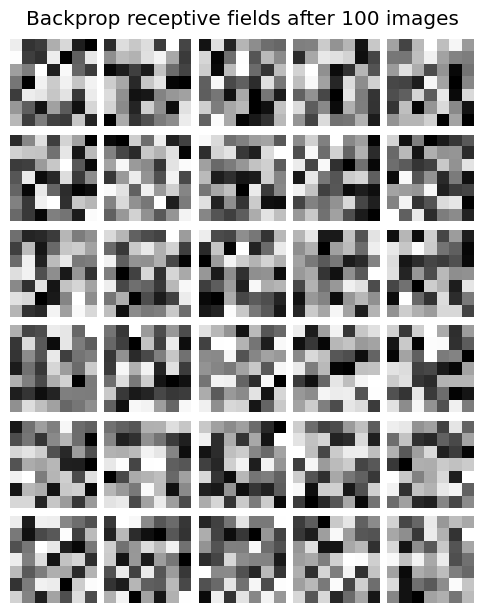

In [599]:
cnnBP = CNN(kernel_size=7, num_conv_filters=30)
cnnBP.train(num_train_steps=100, train_dataloader=train_dataloader, learning_rate=0.01)
fig = cnnBP.plot_conv1_receptive_fields()
fig.savefig('Backprop_receptive_fields_100.png', dpi=300)
fig.savefig('Backprop_receptive_fields_100.svg', dpi=300)

Epoch 1/1:   0%|          | 0/60000 [00:00<?, ?it/s]

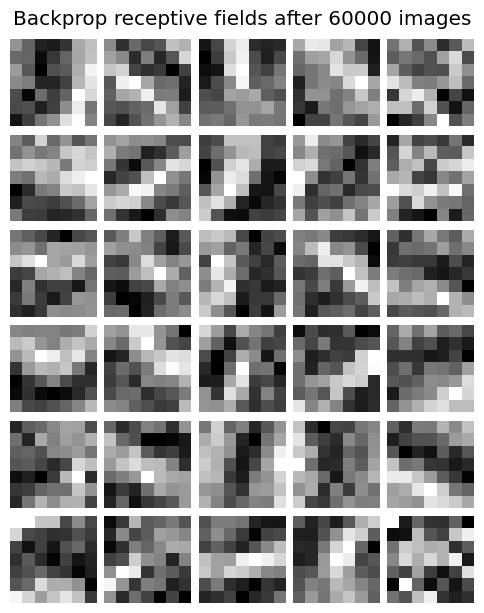

In [600]:
cnnBP = CNN(kernel_size=7, num_conv_filters=30)
cnnBP.train(num_train_steps=60_000, train_dataloader=train_dataloader, learning_rate=0.01)
fig = cnnBP.plot_conv1_receptive_fields()
fig.savefig('Backprop_receptive_fields_60000.png', dpi=300)
fig.savefig('Backprop_receptive_fields_60000.svg', dpi=300)

## BTSP

### 1. Demonstrate basic saccades + learning

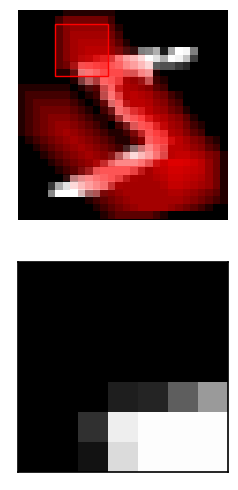

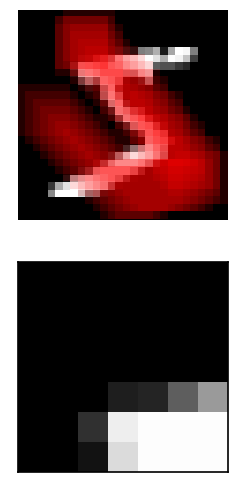

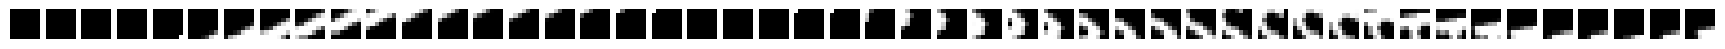

In [674]:
from IPython.display import clear_output, display

def saccade(image, start_x, start_y, kernel_size, saccade_angle, saccade_length, plot=False):
    '''
    Move the convolutional kernel (receptive field) with a saccade of a given and angle.
    '''
    x = start_x # x-coordinate of the top left corner of the receptive field
    y = start_y # y-coordinate of the top left corner of the receptive field
    saccade_angle = np.deg2rad(-saccade_angle)
    image_timeseries = []

    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(6,6))
        ax[0].imshow(image, cmap='gray')
    
    coordinates = []

    # Move the receptive field one pixel at a time
    while len(image_timeseries) < saccade_length:
        while 0 <= x < image.shape[0]-kernel_size and 0 <= y < image.shape[1]-kernel_size:
            # Get the receptive field
            x_approx = round(x)
            y_approx = round(y)
            receptive_field = image[y_approx:y_approx+kernel_size, x_approx:x_approx+kernel_size]
            image_timeseries.append(receptive_field)
            # coordinates.append((x_approx+kernel_size//2, y_approx+kernel_size//2))
            coordinates.append((x+kernel_size//2, y+kernel_size//2))
            
            if plot:
                # interactively plot a square around the receptive field, clearing in every iteration and making a new plot
                clear_output(wait=True)
                filled_square = plt.Rectangle((x_approx-0.6, y_approx-0.6), kernel_size, kernel_size, linewidth=1, edgecolor='none', facecolor='r', alpha=1/kernel_size)
                ax[0].add_patch(filled_square)
                empty_square = plt.Rectangle((x_approx-0.6, y_approx-0.6), kernel_size, kernel_size, linewidth=1, edgecolor='r', facecolor='none')
                ax[0].add_patch(empty_square)
                ax[0].axis('off')
                
                ax[1].cla()
                ax[1].imshow(receptive_field, cmap='gray', vmin=image.min(), vmax=image.max())
                ax[1].set_xticks([])
                ax[1].set_yticks([])
                ax[1].spines['top'].set_visible(True)
                ax[1].spines['right'].set_visible(True)
                display(fig)        
                empty_square.remove()

            # Move the receptive field
            x += np.cos(saccade_angle)
            y += np.sin(saccade_angle)
            if x_approx==round(x) and y_approx==round(y): # if the saccade didn't move the receptive field, take another step in the same direction
                x += np.cos(saccade_angle)
                y += np.sin(saccade_angle)
            
            if len(image_timeseries) >= saccade_length:
                break

        # Change the saccade angle, picking 
        saccade_angle += np.pi + np.random.uniform(-np.pi/2, np.pi/2)
        saccade_angle = saccade_angle % (2*np.pi) # keep the angle between 0 and 2*pi
        x = x_approx + np.cos(saccade_angle)
        y = y_approx + np.sin(saccade_angle)
    
    if plot:
        return image_timeseries, fig
    else:
        return image_timeseries, coordinates

np.random.seed(12)
image = MNIST_train_dataset[0][0][0].numpy()
start_x = 0  #np.random.randint(0, image.shape[0]-kernel_size) # x-coordinate of the top left corner of the receptive field
start_y = 10 #np.random.randint(0, image.shape[1]-kernel_size) # y-coordinate of the top left corner of the receptive field
saccade_angle = -45
kernel_size = 7
saccade_length = 48
image_timeseries, fig  = saccade(image, start_x, start_y, kernel_size, saccade_angle, saccade_length, plot=True)
fig.savefig('saccade.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
fig.savefig('saccade.svg', dpi=300, bbox_inches='tight', pad_inches=0.1)

fig, ax = plt.subplots(1, len(image_timeseries), figsize=(22, 5))
for i,im in enumerate(image_timeseries):
    ax[i].imshow(im, cmap='gray')
    ax[i].axis('off')

In [651]:
# BTSP learning rule

def get_BTSP_function(Wmax, k_pot, k_dep, sig_pot, sig_dep):
    '''
    Returns a callable function that computes the BTSP weight update as a function of the current synaptic weight and
    the overlap between eligibility traces and instructive signals.
    The BTSP function is parameterized by the maximum synaptic weight and sigmoid functions for potentiation and
    depression (scaled by potentiation and depression coefficients).
    '''
    dW = lambda ETxIS, W: (Wmax - W) * k_pot * sig_pot(ETxIS) - W * k_dep * sig_dep(ETxIS)
    return dW

def get_scaled_sigmoid(slope, threshold):
    '''
    Returns a callable function for a scaled sigmoid with the given slope and threshold.
    The sigmoid is scaled so that it goes from 0 to 1 for x in [0,1]
    '''
    peak =  1. / (1. + np.exp(-slope * (1 - threshold)))    # value of sigmoid at x=1
    baseline = 1. / (1. + np.exp(-slope * (0 - threshold))) # value of sigmoid at x=0
    scaled_sigmoid = lambda x: (1. / (1. + np.exp(-slope * (x - threshold))) - baseline) / (peak-baseline)
    return scaled_sigmoid

# BTSP parameters from (Milstein et al., 2021, eLife) Fig.7
sig_pot = get_scaled_sigmoid(slope=4.405, threshold=0.415)
sig_dep = get_scaled_sigmoid(slope=20.0, threshold=0.026)
k_dep = 0.425
k_pot = 1.1097
Wmax = 4.68
btsp_func = get_BTSP_function(Wmax, k_pot, k_dep, sig_pot, sig_dep)

ET_rise_tau=0.3
IS_rise_tau=0.05
ET_decay_tau=1.66
IS_decay_tau=0.44


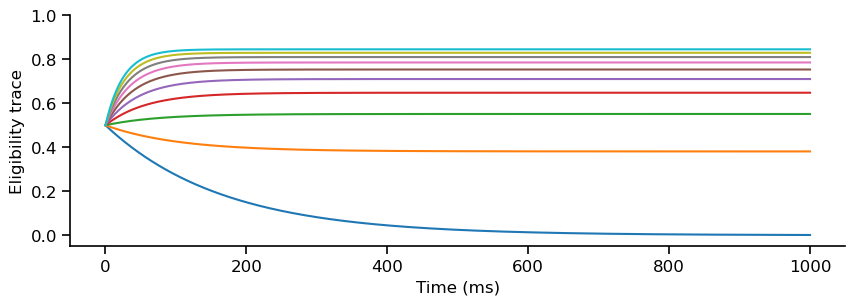

In [652]:
for input in np.linspace(0,1,10):
    ET_init = 0.5
    dt = 0.01
    ET_list = [ET_init] 
    for t in range (1000):
        ET = ET_list[-1]
        dET_rise = (1-ET)*(1-np.exp(-dt*input/(ET_rise_tau)))
        dET_decay = ET*(1-np.exp(-dt/ET_decay_tau))
        dET = dET_rise - dET_decay
        ET_list.append(ET+dET)

    plt.plot(ET_list)
plt.ylim(-0.05,1)
plt.xlabel('Time (ms)')
plt.ylabel('Eligibility trace')
plt.show()

Frame rate: 10.0 Hz


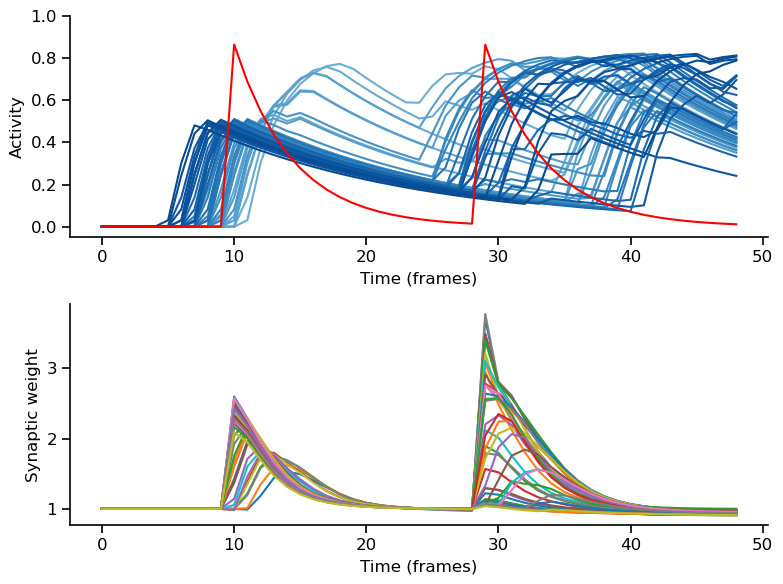

In [653]:
np.random.seed(12)
num_conv_filters = 32

# Initialize ET/IS and weight matrices
kernel_weights = np.ones([num_conv_filters, kernel_size, kernel_size])
# kernel_weights = np.random.rand(5, 5)

# Set runtime parameters
dt = 0.1  # s (dwell time of the receptive field kernel at each location)
framerate = 1/dt  # Hz
print(f'Frame rate: {framerate} Hz')

IS = np.zeros(num_conv_filters)
ET = np.zeros(kernel_size*kernel_size)
ET_history = [np.copy(ET)]
IS_history = [np.copy(IS)]
plateau_history = [np.zeros(num_conv_filters)]
weights_history = [np.copy(kernel_weights.flatten())]

for t,image in enumerate(image_timeseries):
    # Compute eligibility trace
    dET_rise = (1-ET)*(1-np.exp(-dt*image.flatten()/(ET_rise_tau)))
    dET_decay = ET*(1-np.exp(-dt/ET_decay_tau))
    ET += dET_rise - dET_decay
    ET_history.append(np.copy(ET))
    
    # Compute instructive signal
    plateau_probability = 0.05
    plateaus = np.random.rand(num_conv_filters) < plateau_probability
    dIS_rise = (1-IS)*(1-np.exp(-dt*plateaus/IS_rise_tau))
    dIS_decay = IS*(1-np.exp(-dt/IS_decay_tau))
    IS += dIS_rise - dIS_decay
    IS_history.append(np.copy(IS))
    plateau_history.append(plateaus)

    # Compute weight update
    ETxIS = np.outer(IS,ET).flatten()
    dW = btsp_func(ETxIS, kernel_weights.flatten())
    kernel_weights += dW.reshape(num_conv_filters, kernel_size, kernel_size)
    weights_history.append(np.copy(kernel_weights.flatten()))

ET_history = np.array(ET_history)
IS_history = np.array(IS_history)
plateau_history = np.array(plateau_history)
weights_history = np.array(weights_history)

# Generate plots
cell_nr = 1

fig, axes = plt.subplots(2, 1, figsize=(8, 6))
ax = axes[0]
colors_ET = plt.cm.Blues(np.linspace(0.5,0.9,ET_history.shape[1]))
for i in range(ET_history.shape[1]):
    ax.plot(ET_history[:,i], color=colors_ET[i])
# colors_IS = plt.cm.Reds( np.linspace(0.5,0.9,IS_history.shape[1]))
# for i in range(IS_history.shape[1]):
#     ax.plot(IS_history[:,i], color=colors_IS[i])
# ax.plot(ET_history, color='b')
ax.plot(IS_history[:,cell_nr], color='r')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Activity')
ax.set_ylim(-0.05,1) 

ax = axes[1]
weights_history = np.array(weights_history).reshape(-1, num_conv_filters, kernel_size*kernel_size)
ax.plot(weights_history[:,cell_nr])
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Synaptic weight')

plt.tight_layout()
plt.show()

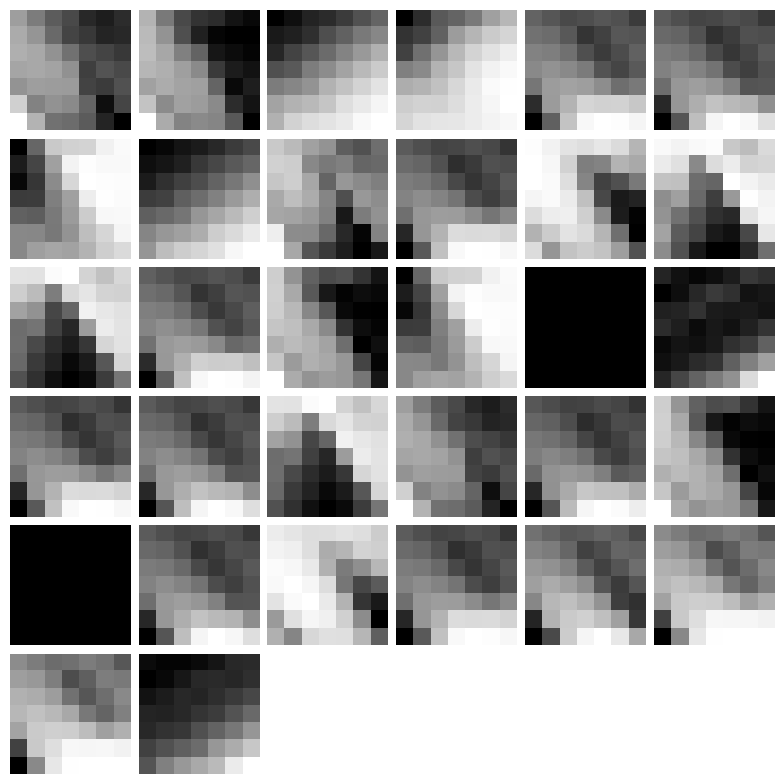

In [654]:
# Plot all the receptive fields

num_rows = int(np.ceil(np.sqrt(num_conv_filters)))
num_cols = int(np.ceil(num_conv_filters / num_rows))
fig, ax = plt.subplots(num_rows, num_cols, figsize=(8, 8))
for i in range(len(ax.flatten())):
    if i < num_conv_filters:
        ax.flatten()[i].imshow(kernel_weights[i], cmap='gray')
    ax.flatten()[i].axis('off')

plt.tight_layout(w_pad=0.5, h_pad=0.5)
plt.show()

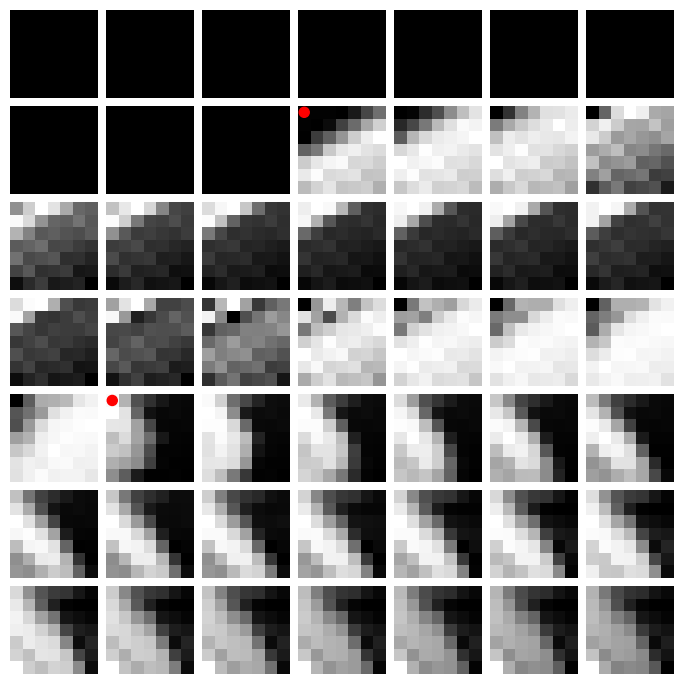

In [655]:
# Plot the receptive field of the first convolutional filter over time
cell_nr = 1
n_rows = np.sqrt(weights_history.shape[0]).astype(int)
n_cols = np.ceil(weights_history.shape[0] / n_rows).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7, 7))

for i, (receptive_field, ax) in enumerate(zip(weights_history[:,cell_nr], axes.flatten())):
    ax.imshow(receptive_field.reshape(kernel_size, kernel_size), cmap='gray')
    ax.axis('off')
    if plateau_history[i,cell_nr]:
        # Plot filled red circle in the corner of the receptive field if plateau signal is active
        circle = plt.Circle((0, 0), 0.4, color='r', fill=True)
        ax.add_artist(circle)

# Remove empty subplots
for i in range(weights_history.shape[0], n_rows*n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.show()
fig.savefig('BTSP_single_conv_filter.png', dpi=300, bbox_inches='tight')
fig.savefig('BTSP_single_conv_filter.svg', dpi=300, bbox_inches='tight')

### 2. Implement CNN with BTSP learning

In [702]:
class CNN_BTSP(torch.nn.Module):
    def __init__(self, num_conv_filters, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.num_conv_filters = num_conv_filters
        self.num_channels = 1
        original_image_dim = 28
        dim_after_maxpool = original_image_dim // 2
        num_output_classes = 10

        self.conv1 = torch.nn.Conv2d(1, num_conv_filters, kernel_size=kernel_size, padding=2)
        self.conv1.weight.requires_grad = False
        self.conv1.bias.requires_grad = False
        self.conv1.weight.fill_(1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(num_conv_filters*dim_after_maxpool*dim_after_maxpool, num_output_classes)

        # Set runtime parameters
        self.dt = 0.05  # s (dwell time of the receptive field kernel at each location)
        self.framerate = 1/self.dt  # Hz
        self.saccade_length = 40
        self.plateau_probability = 0.005
        self._weight_history = []
        self._plateau_history = []
        self._input_history = []
        
        # BTSP parameters from (Milstein et al., 2021, eLife) Fig.7
        sig_pot = get_scaled_sigmoid(slope=4.405, threshold=0.415)
        sig_dep = get_scaled_sigmoid(slope=20.0, threshold=0.026)
        k_dep = 0.425
        k_pot = 1.1097
        Wmax = 4.68
        self.btsp_func = get_BTSP_function(Wmax, k_pot, k_dep, sig_pot, sig_dep)
                
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 32*14*14)
        x = self.fc1(x)
        return x
    
    def conv1_BTSP_weight_update(self, image_timeseries):
        '''
        Compute ET/IS and perform a BTSP weight update from the image timeseries of saccade/trajectory in a single image.
        '''
        # BTSP parameters
        ET_rise_tau=0.3
        IS_rise_tau=0.05
        ET_decay_tau=1.66
        IS_decay_tau=0.44

        # IS = np.zeros(self.num_conv_filters)
        IS = np.zeros(self.conv1.weight.shape[0])
        ET = np.zeros(self.kernel_size * self.kernel_size)
        ET_history = [np.copy(ET)]
        IS_history = [np.copy(IS)]
        plateau_timeseries = [np.zeros(self.num_conv_filters)]
        weight_timeseries = [np.copy(self.conv1.weight.detach().flatten())]

        for image in image_timeseries:
            # Compute eligibility traces
            dET_rise = (1-ET)*(1-np.exp(-self.dt*image.flatten()/(ET_rise_tau)))
            dET_decay = ET*(1-np.exp(-self.dt/ET_decay_tau))
            ET += dET_rise - dET_decay
            ET_history.append(np.copy(ET))
            
            # Compute instructive signals
            plateaus = np.random.rand(self.num_conv_filters) < self.plateau_probability
            dIS_rise = (1-IS)*(1-np.exp(-self.dt*plateaus/IS_rise_tau))
            dIS_decay = IS*(1-np.exp(-self.dt/IS_decay_tau))
            IS += dIS_rise - dIS_decay
            IS_history.append(np.copy(IS))
            plateau_timeseries.append(plateaus)

            # Compute weight updates
            kernel_weights = self.conv1.weight.detach()
            ETxIS = np.outer(IS,ET).flatten()
            dW = btsp_func(ETxIS, kernel_weights.flatten())
            kernel_weights += dW.reshape(self.num_conv_filters, self.num_channels, self.kernel_size, self.kernel_size)
            weight_timeseries.append(np.copy(kernel_weights.flatten()))
        
        return weight_timeseries, plateau_timeseries

    def train(self, train_dataloader, max_steps=None):
        """
        Train the network using the BTSP learning rule.
        """

        for i, data in tqdm(enumerate(train_dataloader, 0), leave=False, total=len(train_dataloader), desc=f'Epoch {epoch+1}/{n_epochs}'):
            image, label = data
            image = image[0,0].numpy() # remove batch and channel dimensions

            start_x = np.random.randint(0, image.shape[0]-self.kernel_size) # x-coordinate of the top left corner of the receptive field
            start_y = np.random.randint(0, image.shape[1]-self.kernel_size) # y-coordinate of the top left corner of the receptive field
            saccade_angle = np.random.randint(0, 360)
            image_timeseries, coordinates = saccade(image, start_x, start_y, self.kernel_size, saccade_angle, self.saccade_length)
            weight_timeseries, plateau_timeseries = self.conv1_BTSP_weight_update(image_timeseries)
            self._weight_history.append(weight_timeseries)
            self._plateau_history.append(plateau_timeseries)
            self._input_history.append((image, coordinates))
            
            if i >= max_steps-1:
                break

    def plot_conv1_receptive_fields(self):
        num_rows = int(np.ceil(np.sqrt(self.num_conv_filters)))
        num_cols = int(np.ceil(self.num_conv_filters / num_rows))
        fig, ax = plt.subplots(num_rows, num_cols, figsize=(5, 6))
        for i in range(len(ax.flatten())):
            if i < self.num_conv_filters:
                ax.flatten()[i].imshow(self.conv1.weight[i][0].detach().numpy(), cmap='gray')
            ax.flatten()[i].axis('off')
        plt.tight_layout(w_pad=0.5, h_pad=0.5)
        plt.suptitle(f'BTSP receptive fields after {len(self.weight_history)} images', y=1.02)
        plt.show()
        return fig
    
    @property
    def weight_history(self):
        return np.array(self._weight_history)
    
    @property
    def plateau_history(self):
        return np.array(self._plateau_history)
    
    @property
    def input_history(self):
        return np.array(self._input_history)

Epoch 1/1:   0%|          | 0/60000 [00:00<?, ?it/s]

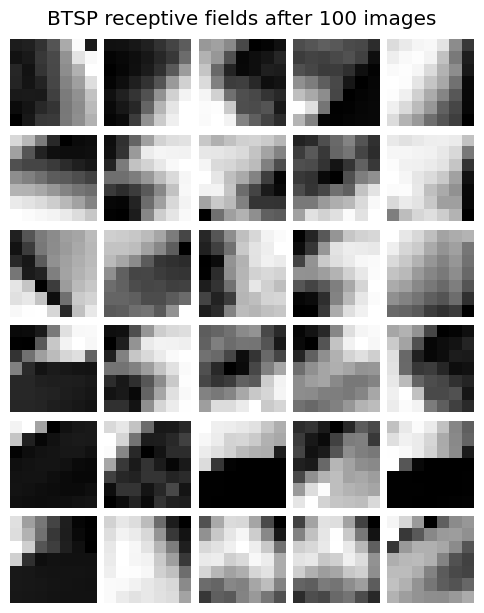

In [703]:
np.random.seed(12)
torch.manual_seed(12)  
cnnBTSP = CNN_BTSP(num_conv_filters=30, kernel_size=7)

cnnBTSP.train(train_dataloader, max_steps=100)
fig = cnnBTSP.plot_conv1_receptive_fields()
fig.savefig('BTSP_receptive_fields.png', dpi=300, bbox_inches='tight')
fig.savefig('BTSP_receptive_fields.svg', dpi=300, bbox_inches='tight')

In [704]:
cnnBTSP.num_conv_filters

30

In [705]:
cnnBTSP.plateau_history.shape

(100, 41, 30)

In [706]:
cnnBTSP.weight_history.shape

(100, 41, 1470)

In [698]:
cnnBTSP.input_history.shape

/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_88415/1987452878.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self._input_history)


(100, 2)

/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_88415/1987452878.py:128: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self._input_history)


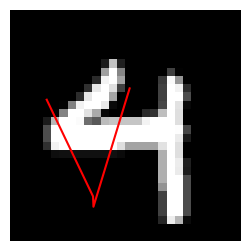

In [697]:
def plot_image_trajectory(image, coordinates, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.imshow(image, cmap='gray')
    ax.plot([c[0] for c in coordinates], [c[1] for c in coordinates], 'r')
    ax.axis('off')
    return ax

image_nr = 0
image, coordinates = cnnBTSP.input_history[image_nr]
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plot_image_trajectory(image, coordinates, ax=ax)
plt.show()

In [ ]:
num_images = 10
num_units = 